In [1]:
# Set up dependencies

%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base=automap_base()
Base.prepare(engine,reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
stn_dict=Base.classes.station
msr_dict=Base.classes.measurement



In [7]:
# Create our session (link) from Python to the DB
session=Session(bind=engine)

fr_stn=session.query(stn_dict).first()
fr_msr=session.query(msr_dict).first()
# show schema of stations
fr_stn.__dict__


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1deff008908>,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'longitude': -157.8168}

In [8]:
# show schema of measurement
fr_msr.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1deff086d48>,
 'tobs': 65.0,
 'id': 1,
 'date': '2010-01-01',
 'station': 'USC00519397',
 'prcp': 0.08}

# Exploratory Climate Analysis

In [9]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results



'''
# This is the way I would do it, if I were not in the class .... 
# Convert date to an integer format
ed_int=int(''.join(c for c in end_date if c.isdigit()))
# Subtract a year
sd_int=en_int-10000
# Then convert all the dates, but I'll do it the way we were taught.
'''

In [10]:
# get the last date in the measurement table and convert to a string
last_date=session.query(msr_dict.date).order_by(msr_dict.date.desc()).first()
last_date=last_date[0]
print(f'The last date in the data is {last_date}')

The last date in the data is 2017-08-23


In [11]:
# Calculate the date 1 year ago from the last data point in the database

#convert the string last date to a date
ld_yr=int(last_date[0:4])
ld_mo=int(last_date[5:7])
ld_dy=int(last_date[8:10])
ld=dt.date(ld_yr,ld_mo,ld_dy)

# set up a one-year decrement
year_ago=dt.timedelta(days=365)

fd=ld-year_ago
print(f'One year before the last date in data is {fd}.')



One year before the last date in data is 2016-08-23.


In [12]:
# Perform a query to retrieve the data and precipitation scores

sel=[msr_dict.id,msr_dict.station,msr_dict.date,
     func.avg(msr_dict.tobs),
     func.max(msr_dict.tobs),
     func.min(msr_dict.tobs),
     func.avg(msr_dict.prcp),
     func.max(msr_dict.prcp),
     func.min(msr_dict.prcp)
    ]

daily_avg=session.query(*sel).\
    filter(msr_dict.date> fd).\
    group_by(msr_dict.date).\
    order_by(msr_dict.date).all()


# The results below are by date ...

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df=pd.DataFrame(daily_avg,columns=['id','station','date','avg_tobs','max_tobs','min_tobs','avg_prcp','max_prcp','min_prcp'])
prcp_df.head()

,id,station,date,avg_tobs,max_tobs,min_tobs,avg_prcp,max_prcp,min_prcp
0,2365,USC00519397,2016-08-24,77.571429,80.0,74.0,1.555000,2.28,0.08
1,7333,USC00514830,2016-08-25,79.428571,81.0,77.0,0.077143,0.21,0.00
2,2367,USC00519397,2016-08-26,80.500000,84.0,78.0,0.016667,0.04,0.00
3,2368,USC00519397,2016-08-27,76.833333,81.0,73.0,0.064000,0.18,0.00
4,2369,USC00519397,2016-08-28,76.000000,81.0,71.0,0.516667,2.07,0.01


In [14]:
prcp_df2=prcp_df.drop(['id','station','avg_tobs','max_tobs','min_tobs','max_prcp','min_prcp'],axis=1)
prcp_df2.head()

,date,avg_prcp
0,2016-08-24,1.555000
1,2016-08-25,0.077143
2,2016-08-26,0.016667
3,2016-08-27,0.064000
4,2016-08-28,0.516667


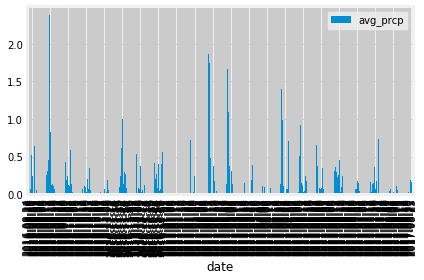

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data

prcp_df2.set_index('date',inplace=True)
prcp_df2.plot.bar()
plt.tight_layout()
plt.show()

# Above is what I understood the instructions to say to do. It does not specify what the precipitation is being averaged over. Above is the daily average for all the stations reporting.  It is not what I would normally do. I do not like the output and do not find it helpful, so I am instead going to produce a line graph of average monthly temperatures by station. I think that may have been what was meant by average precipitation.

In [16]:
# get the average of each station for each month and append it to a dictionary



In [17]:
# Create a pandas using months as index, stations as columns and queried average precipitation as entries
months=["01","02","03","04","05","06","07","08","09","10","11","12"]
mo_df=pd.DataFrame(months,columns=["month"])

sel=[stn_dict.station] 
stations=session.query(*sel).all()
st_df=pd.DataFrame(stations,columns=['station'])



In [18]:
# list of station names with month at end (columns for Pandas)
st=[]
for s in stations:
    st.append(s[0])
st.append('month')



In [19]:
# empty pandas dataframe
ap_df=pd.DataFrame({})

# select the average precipitation for each station by month
sel=[func.avg(msr_dict.prcp)]
for m in months:
    row=[]
    for s in st:
        if s!='month':
            a_p=session.query(*sel).\
                filter(func.strftime("%m",msr_dict.date)==m).\
                filter(msr_dict.station==s).all()
            a_p=a_p[0][0]
            row.append(a_p)
        else:
            row.append(m)
    row=pd.Series(row)
    row=pd.DataFrame([row])
    ap_df=pd.concat([ap_df,row])

# manipulate pandas to index by month and have columns=stations with entries being avg monthly precip.    
ap_df.columns=st
ap_df.index=ap_df['month']
ap_df.drop('month',axis=1)


,USC00519397,USC00513117,USC00514830,USC00517948,USC00518838,USC00519523,USC00519281,USC00511918,USC00516128
month,,,,,,,,,
01,0.040086,0.116327,0.096312,0.046275,0.290392,0.123864,0.179073,0.070391,0.239828
02,0.067361,0.159686,0.146692,0.093860,0.069500,0.143732,0.172301,0.043836,0.233941
03,0.089013,0.210645,0.120375,0.190541,0.406071,0.170749,0.272621,0.079817,0.405882
04,0.034786,0.099958,0.085450,0.035167,0.373636,0.116818,0.188542,0.032840,0.463379
05,0.040208,0.126016,0.105482,0.067500,0.195366,0.085738,0.234516,0.041617,0.369543
06,0.022661,0.118248,0.114192,0.057975,0.094615,0.050044,0.151525,0.015157,0.495748
07,0.048368,0.139955,0.142880,0.030000,0.209474,0.088423,0.207621,0.021761,0.526791
08,0.027922,0.123066,0.105347,0.047846,0.071379,0.099643,0.221903,0.023774,0.443960
09,0.047192,0.127135,0.099437,0.027286,0.018800,0.110000,0.222714,0.025385,0.531667


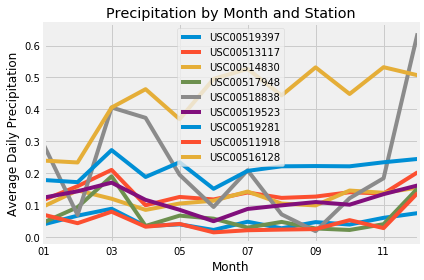

In [20]:
# plot a line graph by station
ap_df.set_index('month',inplace=False)
ap_df.plot.line()
plt.ylabel('Average Daily Precipitation')
plt.xlabel("Month")
plt.title('Precipitation by Month and Station')
plt.tight_layout()
plt.show()


In [21]:
# Use Pandas to calcualte the summary statistics for the precipitation data

ap_df.describe()

,USC00519397,USC00513117,USC00514830,USC00517948,USC00518838,USC00519523,USC00519281,USC00511918,USC00516128
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,0.049427,0.141803,0.121354,0.067707,0.222830,0.115631,0.212683,0.047878,0.433191
std,0.019893,0.033892,0.023579,0.052939,0.178502,0.034152,0.034334,0.034648,0.104779
min,0.022661,0.099958,0.085450,0.022593,0.018800,0.050044,0.151525,0.015157,0.233941
25%,0.038380,0.121861,0.103870,0.033875,0.088806,0.096838,0.186174,0.024982,0.396798
50%,0.043700,0.131877,0.117283,0.047060,0.189991,0.113409,0.221900,0.037228,0.455866
75%,0.062321,0.145477,0.143668,0.074090,0.311203,0.137028,0.234523,0.057642,0.511951
max,0.089013,0.210645,0.154966,0.190541,0.638182,0.170749,0.272621,0.138146,0.532193


#  I'll do it both ways 

In [22]:
# Design a query to show how many stations are available in this dataset?
sel=[stn_dict.station]
stations=session.query(*sel).all()
len(stations)

9

In [23]:
session.query(*sel).count()

9

# The instructions do not say to limit the activity to the last 12 months, so I am using all the information available, not only the most recent. 

In [24]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

# Although there are probalby more direct ways of doing this, it is easier to copy and paste 
# and modify previous work.

sel=[msr_dict.id,msr_dict.station,msr_dict.date,msr_dict.tobs,msr_dict.prcp]

# Get extract of all of the daily reports (id, station, temperature only, but includes NaNs, if provided)
daily_res=session.query(*sel).all()


sel=[msr_dict.tobs]
s_res={}
i=0
for s in st:
    if s!='month':
        s_cnt=session.query(*sel).\
            filter(msr_dict.station==s).count()
        s_res.update({i:[s,s_cnt]})
        i+=1


#s_df.head()
s_df=pd.DataFrame.from_dict(s_res)
s_df=s_df.rename({0:'station',1:'count'}).transpose()
s_df=s_df.sort_values(by='count',ascending=False)
s_df.index=s_df['station']
max_stn=s_df.iloc[0,0]
s_df=s_df.drop('station',axis=1)
print(s_df,'\n')
print('Station with most rows: ',max_stn,' with ',s_df.iloc[0,0],' rows.')

            count
station          
USC00519281  2772
USC00519397  2724
USC00513117  2709
USC00519523  2669
USC00516128  2612
USC00514830  2202
USC00511918  1979
USC00517948  1372
USC00518838   511 

Station with most rows:  USC00519281  with  2772  rows.


# This is extra for cosmetics ... to print name of station

In [25]:
# Create a pandas of stations and their names
sel=[stn_dict.name,stn_dict.station]

stn_query=session.query(*sel).all()

stn_df=pd.DataFrame(stn_query,columns=['name','station'])
stn_df.index=stn_df['station']
stn_df=stn_df.drop('station',axis=1)
print(stn_df,'\n')
print('Aloha!')

                                               name
station                                            
USC00519397                    WAIKIKI 717.2, HI US
USC00513117                    KANEOHE 838.1, HI US
USC00514830  KUALOA RANCH HEADQUARTERS 886.9, HI US
USC00517948                       PEARL CITY, HI US
USC00518838              UPPER WAHIAWA 874.3, HI US
USC00519523      WAIMANALO EXPERIMENTAL FARM, HI US
USC00519281                     WAIHEE 837.5, HI US
USC00511918       HONOLULU OBSERVATORY 702.2, HI US
USC00516128            MANOA LYON ARBO 785.2, HI US 

Aloha!


In [27]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

sel=[msr_dict.station,func.min(msr_dict.tobs),func.max(msr_dict.tobs),func.avg(msr_dict.tobs)]
active_stn = session.query(*sel).\
        filter(msr_dict.station == max_stn).all()
active_stn=active_stn[0]
    
name=stn_df.loc[active_stn[0]][0]
print(f'The most active station is : {active_stn[0]} or {name}')
print(f'The lowest recorded temperature there was: {active_stn[1]}')
print(f'The highest recorded temperature there was: {active_stn[2]}')
print(f'The average recorded temperature there was: {round(active_stn[3],1)}')
print('\nMahalo!')

The most active station is : USC00519281 or WAIHEE 837.5, HI US
The lowest recorded temperature there was: 54.0
The highest recorded temperature there was: 85.0
The average recorded temperature there was: 71.7

Mahalo!


In [28]:

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram





In [29]:
# Choose the station with the highest number of temperature observations.

# Remove any reports with missing temperatures

sel=[msr_dict.tobs]

s_res={}
i=0
for s in st:
    if s!='month':
        s_cnt=session.query(*sel).\
            filter(msr_dict.station==s).\
            filter(msr_dict.tobs is not None).count()
        s_res.update({i:[s,s_cnt]})
        i+=1
        
# Choose the station with the highest number of temperature observations.

s_df=pd.DataFrame.from_dict(s_res)
s_df=s_df.rename({0:'station',1:'count'}).transpose()
s_df=s_df.sort_values(by='count',ascending=False)
s_df.index=s_df['station']

max_stn=s_df.iloc[0,0]
print(s_df,'\n')
print('Station with max number of temperature measurements is ',max_stn,'.')

                 station count
station                       
USC00519281  USC00519281  2772
USC00519397  USC00519397  2724
USC00513117  USC00513117  2709
USC00519523  USC00519523  2669
USC00516128  USC00516128  2612
USC00514830  USC00514830  2202
USC00511918  USC00511918  1979
USC00517948  USC00517948  1372
USC00518838  USC00518838   511 

Station with max number of temperature measurements is  USC00519281 .


In [30]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

sel=[msr_dict.station,func.min(msr_dict.tobs),func.max(msr_dict.tobs),func.avg(msr_dict.tobs)]
active_temp = session.query(*sel).\
        filter(msr_dict.station == max_stn).\
        filter(msr_dict.date>fd).all()
active_temp=active_temp[0]
    
name=stn_df.loc[active_temp[0]][0]
print(f'The station with the most reported temperatures is : {active_temp[0]} or {name}')
print(f'The lowest recorded temperature in the last 12 months reported was: {active_temp[1]}')
print(f'The highest recorded temperature in the last 12 months reported was: {active_temp[2]}')
print(f'The average recorded temperature in the last 12 months reported was: {round(active_temp[3],1)}')
print('\nA hui hou ...')

The station with the most reported temperatures is : USC00519281 or WAIHEE 837.5, HI US
The lowest recorded temperature in the last 12 months reported was: 59.0
The highest recorded temperature in the last 12 months reported was: 83.0
The average recorded temperature in the last 12 months reported was: 73.1

A hui hou ...


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
